# Load MCMC set up notebook

In [1]:
import os
os.chdir('/home/tzd/fs03/d1/tzd/Data_analysis/RAworkflow/MCMC_Refactored_Notebooks')
%run ./MCMC_Method_ObservationData_95th_mean_IQR.ipynb

boxes().shape[0]
# getNoASGM():       => Hg0no_ASGM dataframe; in correct units
# get_model(region): => Hg0_modified; in correct units (takes gridbox region in Peru as input)
# getLoRes():        => Hg0 baseline with ASGM low resulution in correct units
# getHiRes():        => Hg0 baseline with ASGM high resulution in correct units
# getNoASGM():       => Hg0 baseline without ASGM low resulution in correct units
# get_obs_d():       => obs_Hg0; original observations daily mean values
# get_detrended_obs(): => Obs_detrended; return detrended observations
# get_detrended_model(model): => This function takes in a dataframe of model outputs 
                                and returns the detrended version of that model output
# getObsIQR(obs): This function takes observations and returns the IQR 
# getIQR_Dd(model): This function takes in a dataframe of model outputs and returns the detrended IQR
# getIQR(model): => This function takes in a dataframe of model outputs and returns the IQR
#

/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [2]:
import warnings
from math import sqrt
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

In [3]:
os.chdir('/home/tzd/fs03/d1/tzd/Data_analysis/RAworkflow')

# Plot functions

In [4]:
def plotChain(sampler):
    #%% Plot chain results
    fig= plt.figure( figsize=[8,5])
    ax= fig.add_subplot(111)
    res=plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)
    SPuno_truval = scalors['spun'][0]
    plt.axhline(SPuno_truval, color='blue')
    ax.set_ylabel('Hg$^0$ emissions (Mt yr$^{-1}$)', fontsize = 14)
    ax.set_xlabel('Length of Chains')
    plt.show()

In [5]:
def plotCorner(sampler,title):
    #%% Plot corner plots to visualize 1D and 2D spreads between the parameters we are testing, and get some uncertainties on our paraemter estimations
    #True_Emissions = [7.748216414, 11.66649464,1.38677, 13.6339, 18.9904]
    labels = ['South Puno','North Puno','Madre de Dios','Arequipa','Apurimac']
    samples = sampler.flatchain
    fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.025, 0.5, 0.975])#,truths=True_Emissions,truth_color='blue'
    fig.suptitle(title,x=0.6,fontsize=16,fontweight="bold")
    return fig

In [6]:
def plotBox(sampler,title):
    samples = sampler.flatchain
    labels = ['South Puno','North Puno','Madre de Dios','Arequipa','Apurimac']
    dfSamples=pd.DataFrame(samples,columns=labels)
    dfSamples['Puno']=dfSamples['South Puno']+dfSamples['North Puno']
    dfSamples=dfSamples[['Puno','Madre de Dios','Arequipa','Apurimac']]
    
    fig= plt.figure( figsize=[8,5])
    ax= fig.add_subplot(111)
    bpdict = dfSamples.boxplot(whis=[5, 95], return_type='dict')
    posi=[0.05,0.20,0.3,0.45,0.55,0.7,0.8,0.95]

    #ax.axhline(7.75,xmin=0, xmax=0.20,color = 'blue',label='GMA18: 7.75 Mt')
    ax.axhline(19.42,xmin=posi[0], xmax=posi[1],color = 'orange',label='GMA18: 19.42 Mt')
    ax.axhline(1.39, xmin=posi[2], xmax=posi[3],color = 'green',label='GMA18: 1.39 Mt')
    ax.axhline(13.63, xmin=posi[4], xmax=posi[5],color = 'red',label='GMA18: 13.63 Mt')
    ax.axhline(18.99, xmin=posi[6], xmax=posi[7],color = 'darkviolet',label='GMA18: 18.99 Mt')
    ax.axhline(19.73, xmin=posi[0], xmax=posi[1],color = 'orange',linestyle = '--',label='AGC Puno: 19.73 Mt')
    ax.axhline(54.46,xmin=posi[2], xmax=posi[3],color='green',linestyle = '--',label='AGC Madre de Dios: 54.46 Mt')
    ax.axhline(23.86,xmin=posi[4], xmax=posi[5],color='red',linestyle = '--',label='AGC Arequipa: 23.86 Mt')
    ax.axhline(10,xmin=posi[6], xmax=posi[7],color='darkviolet',linestyle = '--',label='AGC Cusco + Ayacucho: 10 Mt')
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    ax.set_ylabel('Hg$^0$ emissions (Mt yr$^{-1}$)',fontsize=12,fontweight="bold")
    ax.set_title(title, fontsize=12,fontweight="bold")
    plt.grid(False)
    plt.ylim(-2, 105)
    plt.show()
    return fig

In [7]:
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# Invetigations to be carried out description


We are using the MCMC algorithm to figure out the distributions of 5 different parameters using different metrics. The metrics being used to compare the Hg concentrations time series are:
* Mean 
* IQR
* 95th percentile range 

With each of these metrics, we investigate the following:
* The effect of the number of sites used as reference by the algorithm
* The effect of the size of the error

# Comparing the different metrics against each other


To compare the metrics against each other we need to choose the error that we are going to use and the number of sites.
1. Error=0.00001
2. Number of Sites =5

## Run simulations and store samples from the  Metrics

In [8]:
data = obs_Hg0_d['value']
res = bootstrap((data,),  np.mean)
y_err = (np.array(res.standard_error)).mean()

init = np.array([7.75, 11.67,1.39, 13.63, 18.99]) #[7.75, 11.66, 50, 23.86, 10]
metrics=['mean','95th','iqr']
error=y_err
ref_sites=0
super_metric_dict={}
for metric in metrics:
     #select the model based on the metric being used
    model = set_metric(metric)
    # initialize the constant teerms based on the right model
    ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs=initEmcee(ref_sites)
    #run MCMC simulation
    sampler=run_simulation(ref_sites,metric,init)
    super_metric_dict[metric]= sampler
    #create corner plot

model metric is mean
The true value of y is: 0.9023238248653249 

the error is: 0.007646245778982544
Running burn-in...
Running production...
model metric is 95th percentile
The true value of y is: 0.5753214210271835 
 
the error is: 0.05804412066735648
Running burn-in...
Running production...
model metric is IQR
Running burn-in...
Running production...


## Create Plots for the different Metrics

### create function for finding absolute error

In [9]:
#create function for finding absolute error
def calc_absE(sampler):
    samples = sampler.flatchain
    labels = ['South Puno','North Puno','Madre de Dios','Arequipa','Apurimac']
    dfSamples=pd.DataFrame(samples,columns=labels)
    dfSamples['Puno']=dfSamples['South Puno']+dfSamples['North Puno']
    dfSamples=dfSamples[['Puno','Madre de Dios','Arequipa','Apurimac']]
#     print('\n')
#     print(dfSamples.describe())
    df_pred=dfSamples.mean()
    df_true=pd.DataFrame([{'Puno':19.73,'Madre de Dios':54.46,'Arequipa':23.86,'Apurimac':10}])
    #df_preVtrue['trueVal']=  df_true[0]
    #print(df_preVtrue)
    print('\n')
    df_abse=abs(df_pred-df_true)
#     print(df_abse.T[0].to_dict())
#     print('\n')
    new_samples =  sampler.flatchain
    new_samples[np.argmax(sampler.flatlnprobability)]
    mse = mean_squared_error(np.array([7.75, 11.66, 50, 23.86, 10]),new_samples[np.argmax(sampler.flatlnprobability)])
            # calculate rmse
    rmse = sqrt(mse)
    return df_abse.T[0].to_dict()

In [10]:
# sampler=super_metric_dict['mean']
# new_samples =  sampler.flatchain
# new_samples[np.argmax(sampler.flatlnprobability)]
# mse = mean_squared_error(7.75,new_samples[np.argmax(sampler.flatlnprobability)][0])
# 		# calculate rmse
# rmse = sqrt(mse)

# # evaluate_forecasts

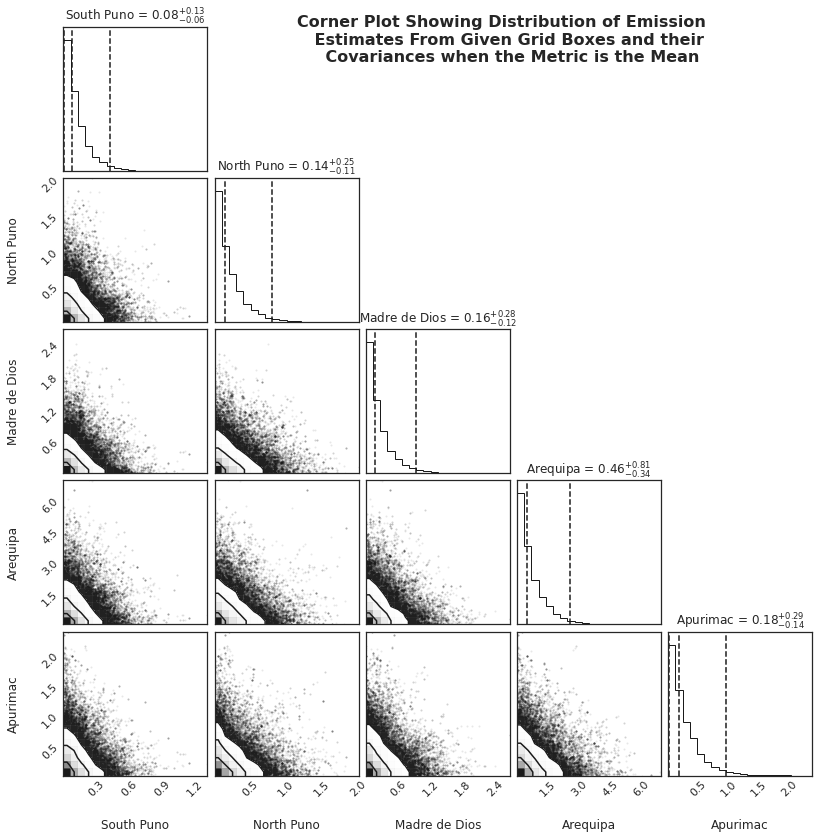

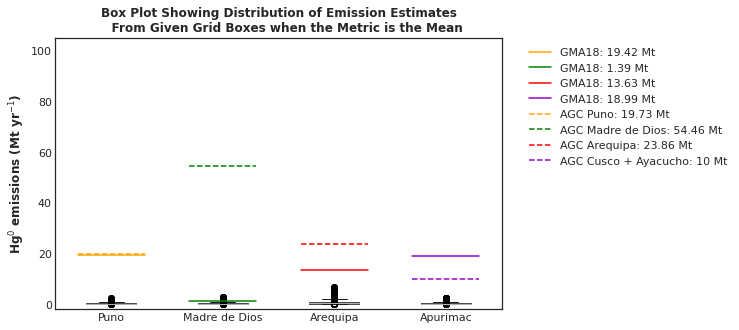

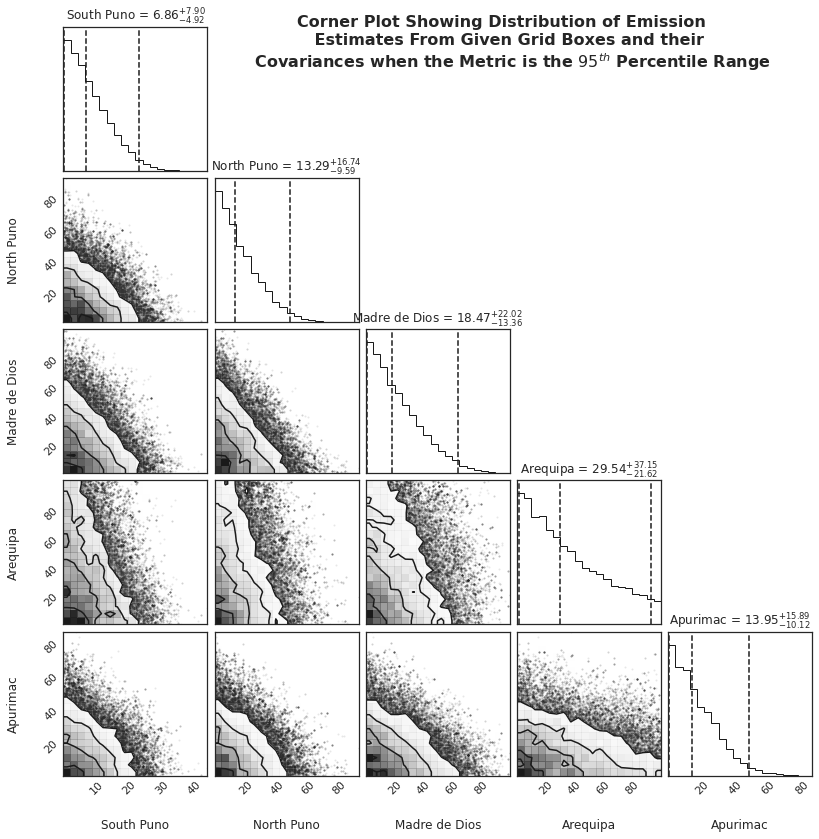

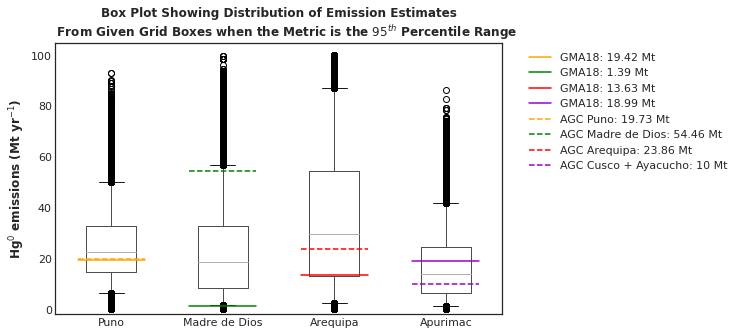

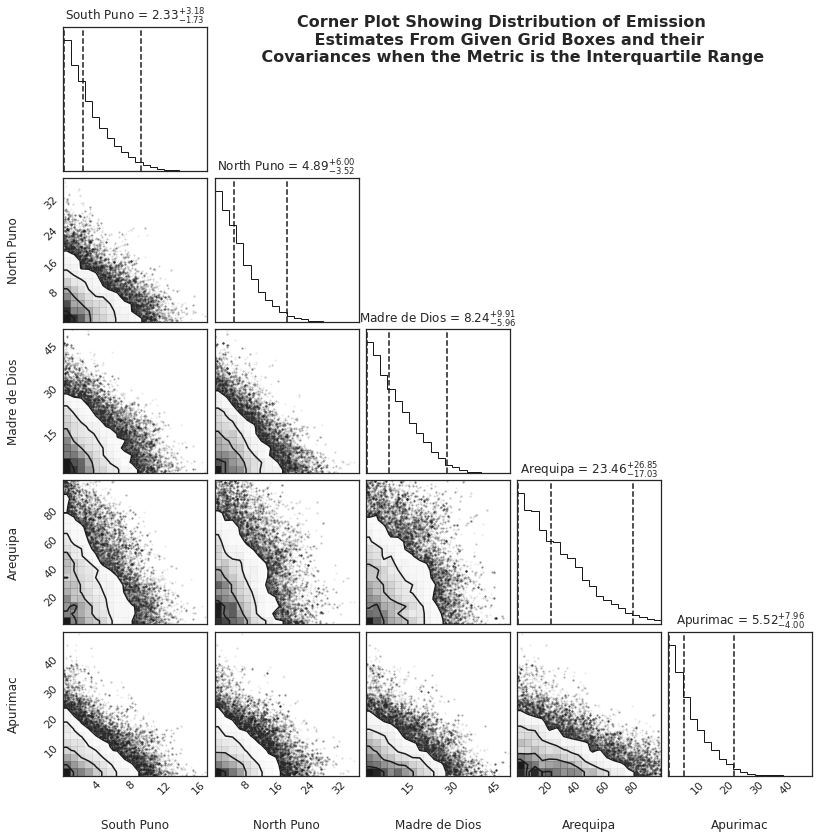

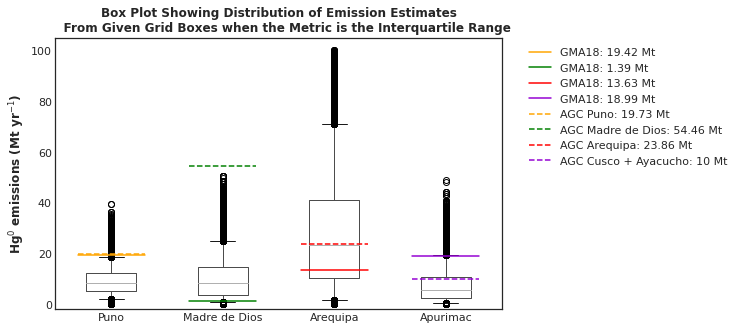

In [11]:

CompareMetric={}

for metric in metrics:
    if metric=='mean':
        met='Mean'
    elif metric=='95th':
        met= '$95^{th}$ Percentile Range'
    else:
        met= 'Interquartile Range'
    sampler=super_metric_dict[metric]
    #create corner plots
    corner_title= '''Corner Plot Showing Distribution of Emission
    Estimates From Given Grid Boxes and their 
    Covariances when the Metric is the '''+met
    
    plotCorner(sampler,corner_title)
    #create boxplot 
    box_title= '''Box Plot Showing Distribution of Emission Estimates
    From Given Grid Boxes when the Metric is the '''+met 
    #df_metric['Puno']=df_metric['South Puno']+df_metric['North Puno']
    plotBox(sampler,box_title)
    #df_metricv2=df_metric[['Madre de Dios','Arequipa','Apurimac','Puno']]
    
    # store dataframe of emission estimate distibutions iqr in dictionary
    #find absolute mean error between mode of MCMC and the true values 
    # df_preVtrue=df_metric.mode().T
    # df_preVtrue['trueVal']= np.array([19.73,54.46, 23.86, 10])
    # df_abse=abs(df_preVtrue['trueVal']-df_preVtrue[0])
    df_abse=calc_absE(sampler)
    CompareMetric[metric]= df_abse

## Plot Absolute Error

In [12]:
pd.DataFrame(CompareMetric).T

,Puno,Madre de Dios,Arequipa,Apurimac
mean,19.403438,54.216327,23.175281,9.736433
95th,4.990640,32.084161,11.601706,6.799661
iqr,10.675757,44.453258,4.098053,2.744624


In [13]:
CompareMetric

{'mean': {'Puno': 19.40343767015419,
  'Madre de Dios': 54.2163269432957,
  'Arequipa': 23.175280677539725,
  'Apurimac': 9.736433115580667},
 '95th': {'Puno': 4.990639502311456,
  'Madre de Dios': 32.08416069822897,
  'Arequipa': 11.60170577535407,
  'Apurimac': 6.7996611474771775},
 'iqr': {'Puno': 10.675756645701261,
  'Madre de Dios': 44.45325842660134,
  'Arequipa': 4.098053408251861,
  'Apurimac': 2.744624275320513}}

           Puno  Madre de Dios   Arequipa  Apurimac
mean  19.403438      54.216327  23.175281  9.736433
95th   4.990640      32.084161  11.601706  6.799661
iqr   10.675757      44.453258   4.098053  2.744624


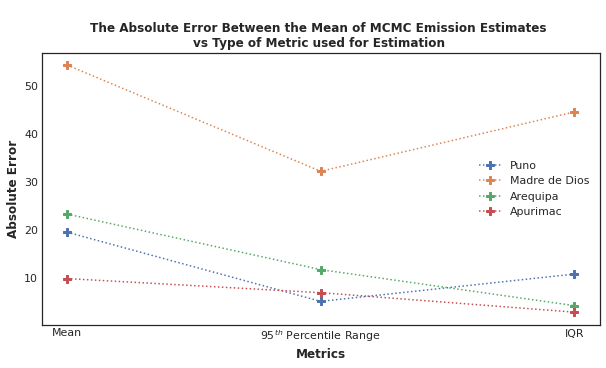

In [14]:
df_CompareMetric=pd.DataFrame(CompareMetric).T
regs=['Puno','Madre de Dios','Arequipa','Apurimac']
df_CompareMetric.rename(columns={0:regs[0],1:regs[1],2:regs[2],3:regs[3]},inplace=True)
print(df_CompareMetric)
fig= plt.figure( figsize=[10,5])
err_text=str("{:.2e}".format(error))
Title='''
The Absolute Error Between the Mean of MCMC Emission Estimates 
vs Type of Metric used for Estimation '''
ax= fig.add_subplot(111)
ax.set_title(Title, size=12,fontweight="bold")
ax.set_ylabel('Absolute Error', fontsize = 12,fontweight="bold")
ax.set_xlabel('Metrics', fontsize = 12,fontweight="bold")
for reg in regs:
    ax.plot(['Mean','$95^{th}$ Percentile Range','IQR'],df_CompareMetric[reg],'P:',ms = 8,label=reg)
ax.legend()
plt.show()
    

# Create plots showing how the error of the posterior emission distibutions change as the error term in the simulation decreases

## Using IQR as Metric

### Generate simulation results

In [ ]:
#calculate initial error based on data
data = obs_Hg0_d['value']
res = bootstrap((data,),  fun_iqr)
y_err = (np.array(res.standard_error)).mean()
y_err
#specify the number of sites
ref_sites=0 # 0 is equivalent to one site 
#initialize the priors
init = np.array([7.75, 11.66, 54, 23.86, 1.5]) 
#set up dictionary for capturing the IQRs for each error per site
error_dict={}
iqr_super_dict={}
for i in range(2,20,2):
    print("The error in this is run: ",y_err)
    metric = 'iqr'
    model = set_metric(metric)
    ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs=initEmcee(ref_sites)
    sampler=run_simulation_error(ref_sites,metric,init,y_err)
    
    #store simulation results in the super dictionary
    iqr_super_dict[i]=sampler
    error_dict[i]=y_err
    y_err=y_err*(0.5**i)   


### Generate the Corner plots and Box plots for IQR

In [ ]:

iqr_errorVerror={}
for i in range(2,20,2):
    y_err=error_dict[i]
    
    sampler=iqr_super_dict[i]
    # plot corner 
    corner_title= '''
    Corner Plot Showing Distribution of Emission 
    Estimates From Given Grid Boxes and their 
    Covariances when the Error is: '''+str("{:.2e}".format(y_err))
    cornerplot=plotCorner(sampler,corner_title)
    CornerFigName='cornerplot_IQR'+str(i)
    cornerplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+CornerFigName)
    
    #plot boxplot
    box_title= '''
    Box Plot Showing Distribution of Emission Estimates
    From Given Grid Boxes when the Error is: '''+str("{:.2e}".format(y_err))
    boxplot=plotBox(sampler,box_title)
    BoxFigName='boxplot_IQR'+str(i)
    boxplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+ BoxFigName)
    #rangeVerror[y_err]=df.apply(find_iqr)
    #y_err=y_err*0.5
    err_sci=str("{:.2e}".format(y_err))
    # df_preVtrue=df_iqr.mode().T
    # df_preVtrue['trueVal']=np.array([19.73,54.46, 23.86, 10])
    # df_abse=abs(df_preVtrue['trueVal']-df_preVtrue[0])
    df_abse=calc_absE(sampler)
    iqr_errorVerror[err_sci]= df_abse
    


### Plot Absolute Errors for IQR

In [ ]:
df_rangeVerror=pd.DataFrame(iqr_errorVerror).T 
df_error=df_rangeVerror.reset_index()
fig= plt.figure( figsize=[16,8])
ax= fig.add_subplot(111)
df_error[['Puno','Madre de Dios','Arequipa','Apurimac']].plot(ax=ax)
xtics=list(df_error['index'])


Title='''
How the Absolute Error Between the Mode of MCMC Emission Estimates and the AGC 
Emission Estimates changes as the Error used in the MCMC Run when the Metric is the IQR'''

ax.legend()
ax.set_ylabel('Absolute Error', fontsize = 14,fontweight="bold")
ax.set_xlabel('Error Used in MCMC Run', fontsize = 14,fontweight="bold")
ax.set_title(Title, size=18,fontweight="bold")
ax.set_xticks(list(range(len(xtics))))
ax.set_xticklabels(xtics)
plt.ylim(-2, 80)
plt.show()
fig.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/abs_errorVmcmc_error_iqr')

## Using 95th as Metric

### Generate the simulation results

In [62]:
#calculate initial error based on data
data = obs_Hg0_d['value']
res = bootstrap((data,),  fun_95th)
y_err = (np.array(res.standard_error)).mean()
y_err
#specify the number of sites
ref_sites=0 # 0 is equivalent to one site 
#initialize the priors
init = np.array([7.75, 11.66, 54, 23.86, 1.5]) 
#set up dictionary for capturing the IQRs for each error per site
error_dict_95th={}
super_dict_95th={}
for i in range(2,20,2):
    print("The error in this is run: ",y_err)
    metric = '95th'
    model = set_metric(metric)
    ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs=initEmcee(ref_sites)
    sampler=run_simulation_error(ref_sites,metric,init,y_err)
    
    #store simulation results in the super dictionary
    super_dict_95th[i]=sampler
    error_dict_95th[i]=y_err
    y_err=y_err*(0.5**i)   

The error in this is run:  0.03638316412863316
model metric is 95th percentile


/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future ve

The true value of y is: 0.6290249298067406 
 
the error is: 0.03638316412863316
Running burn-in...
Running production...
The error in this is run:  0.00909579103215829
model metric is 95th percentile


/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future ve

The true value of y is: 0.6290249298067406 
 
the error is: 0.00909579103215829
Running burn-in...
Running production...
The error in this is run:  0.0005684869395098932
model metric is 95th percentile


/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future ve

The true value of y is: 0.6290249298067406 
 
the error is: 0.0005684869395098932
Running burn-in...
Running production...
The error in this is run:  8.88260842984208e-06
model metric is 95th percentile


/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future ve

The true value of y is: 0.6290249298067406 
 
the error is: 8.88260842984208e-06
Running burn-in...
Running production...
The error in this is run:  3.469768917907063e-08
model metric is 95th percentile


/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future ve

The true value of y is: 0.6290249298067406 
 
the error is: 3.469768917907063e-08
Running burn-in...
Running production...
The error in this is run:  3.388446208893616e-11
model metric is 95th percentile


/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future ve

The true value of y is: 0.6290249298067406 
 
the error is: 3.388446208893616e-11
Running burn-in...
Running production...
The error in this is run:  8.27257375218168e-15
model metric is 95th percentile


/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future ve

The true value of y is: 0.6290249298067406 
 
the error is: 8.27257375218168e-15
Running burn-in...
Running production...
The error in this is run:  5.049178315540576e-19
model metric is 95th percentile


/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future ve

The true value of y is: 0.6290249298067406 
 
the error is: 5.049178315540576e-19
Running burn-in...
Running production...
The error in this is run:  7.704434685578271e-24
model metric is 95th percentile


/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future ve

The true value of y is: 0.6290249298067406 
 
the error is: 7.704434685578271e-24
Running burn-in...
Running production...


### Generate the Corner plots and Box plots for 95th % range

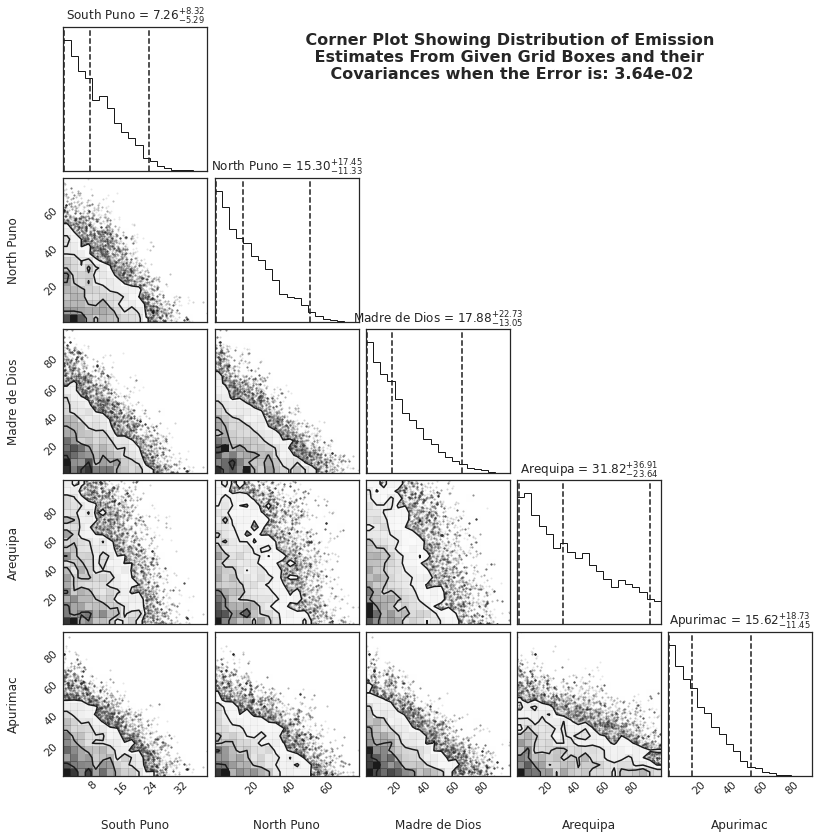

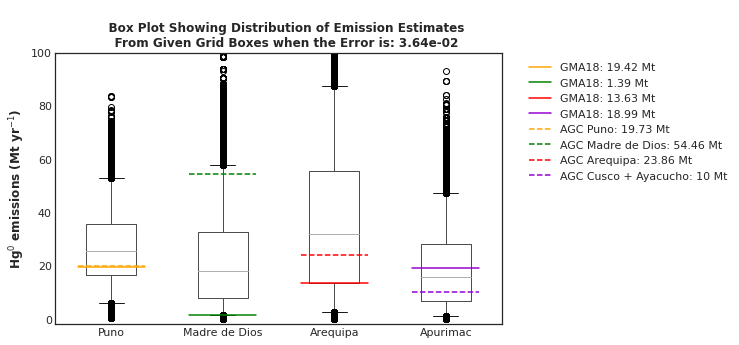



               Puno  Madre de Dios      Arequipa      Apurimac
count  50000.000000   50000.000000  50000.000000  50000.000000
mean      26.810495      22.282963     36.631862     18.938539
std       13.881757      17.914038     26.855445     14.776188
min        0.196574       0.001032      0.002609      0.005196
25%       16.615198       7.910488     13.383170      6.872280
50%       25.527469      17.883637     31.820274     15.623995
75%       35.648401      32.801921     55.663881     27.976795
max       83.523738      98.869709     99.998532     93.238763


{'Puno': 7.08049544207071, 'Madre de Dios': 32.177037373417335, 'Arequipa': 12.771862056581902, 'Apurimac': 8.938538818965846}




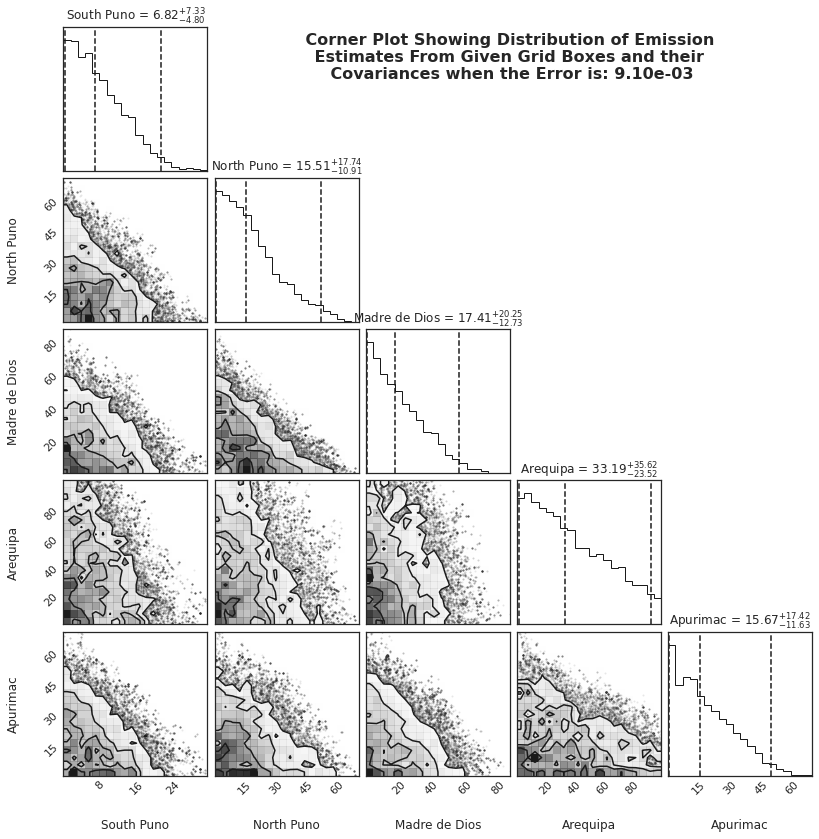

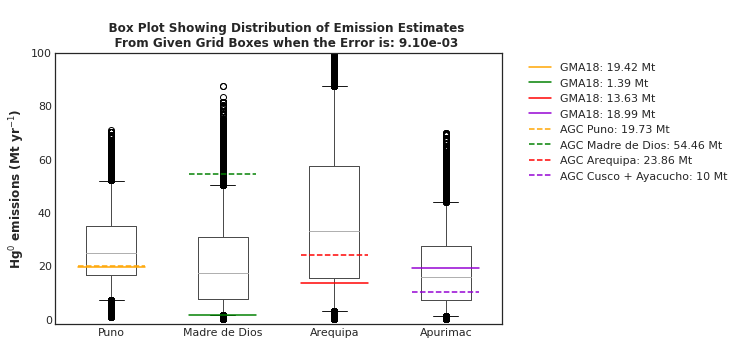



               Puno  Madre de Dios      Arequipa      Apurimac
count  50000.000000   50000.000000  50000.000000  50000.000000
mean      26.385878      20.579482     37.901363     18.384406
std       13.405579      15.654518     26.405120     13.677293
min        0.843747       0.002081      0.003661      0.002058
25%       16.387711       7.532309     15.416120      7.200972
50%       24.909245      17.410098     33.194625     15.671485
75%       34.730905      30.677314     57.526048     27.563182
max       70.860646      87.303470     99.990677     69.887621


{'Puno': 6.655877729408555, 'Madre de Dios': 33.88051753869036, 'Arequipa': 14.041363492150872, 'Apurimac': 8.38440627462909}




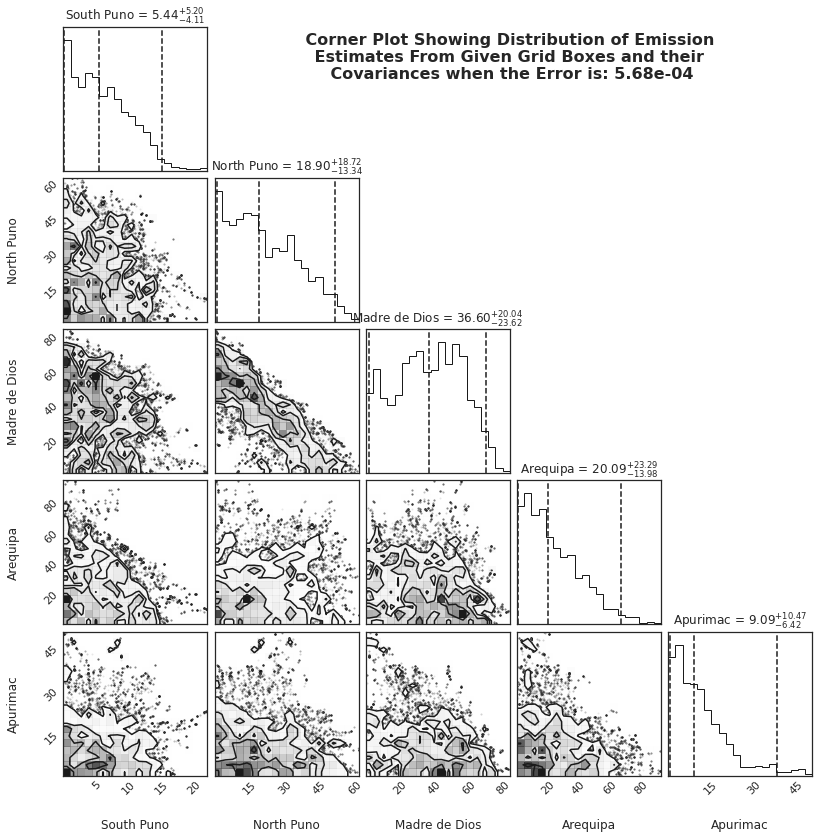

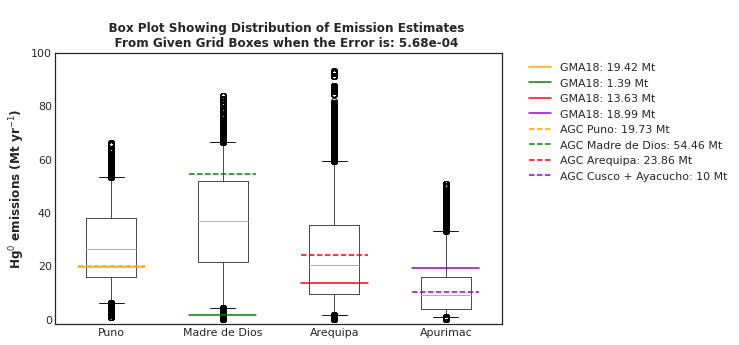



               Puno  Madre de Dios      Arequipa      Apurimac
count  50000.000000   50000.000000  50000.000000  50000.000000
mean      27.413541      36.045409     24.139936     11.405233
std       14.537060      19.359758     18.210468      9.760704
min        0.592333       0.021196      0.004063      0.002811
25%       15.770479      21.414445      9.342328      3.917893
50%       26.194480      36.603819     20.086349      9.090012
75%       37.975109      51.724935     35.440785     15.637555
max       65.902983      83.633180     93.205068     50.506625


{'Puno': 7.683540875308122, 'Madre de Dios': 18.414591307816494, 'Arequipa': 0.2799355499698031, 'Apurimac': 1.405232532181362}




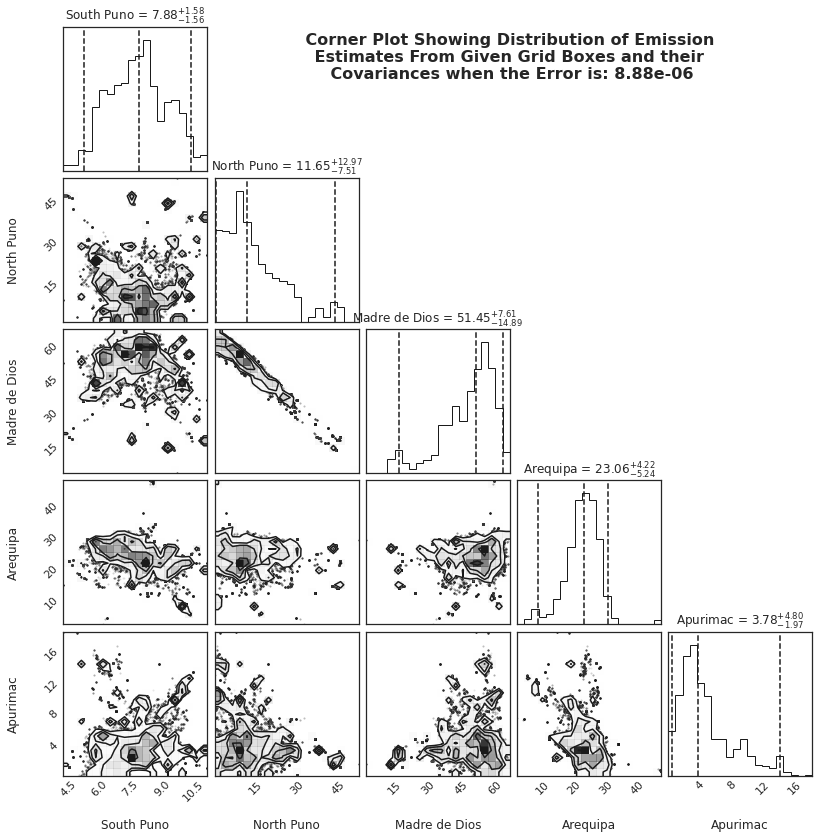

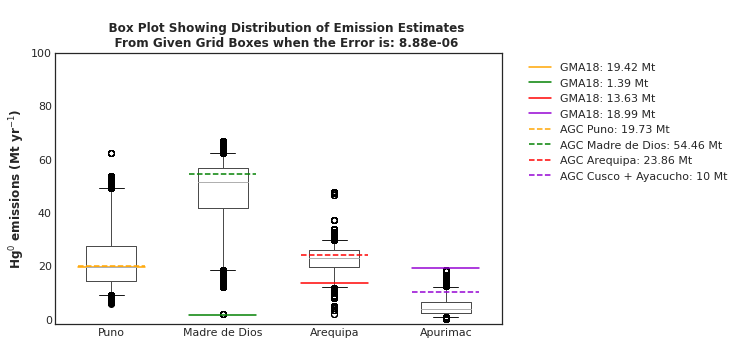



               Puno  Madre de Dios      Arequipa      Apurimac
count  50000.000000   50000.000000  50000.000000  50000.000000
mean      22.083318      48.019355     22.473081      4.745852
std       10.827449      11.995591      5.508092      3.406646
min        5.793239       1.822429      1.798816      0.000311
25%       14.278353      41.629001     19.658127      2.418329
50%       19.583313      51.452930     23.062846      3.784074
75%       27.398403      56.755802     26.063631      6.191474
max       62.289947      66.830322     47.504456     18.207951


{'Puno': 2.3533178158124244, 'Madre de Dios': 6.440644510596293, 'Arequipa': 1.3869192718159304, 'Apurimac': 5.254147822520083}




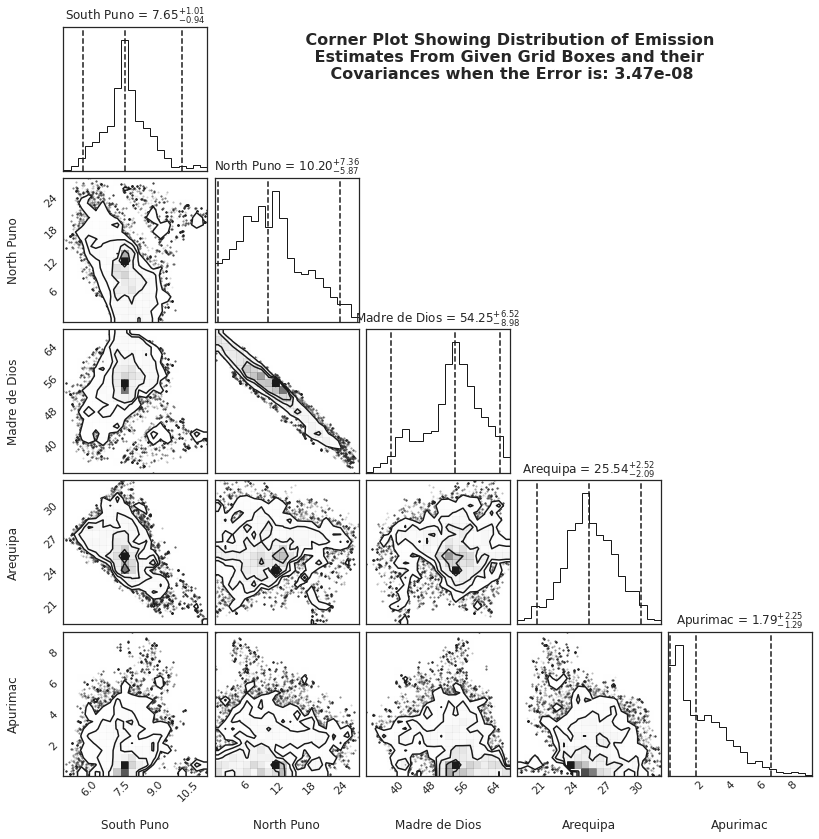

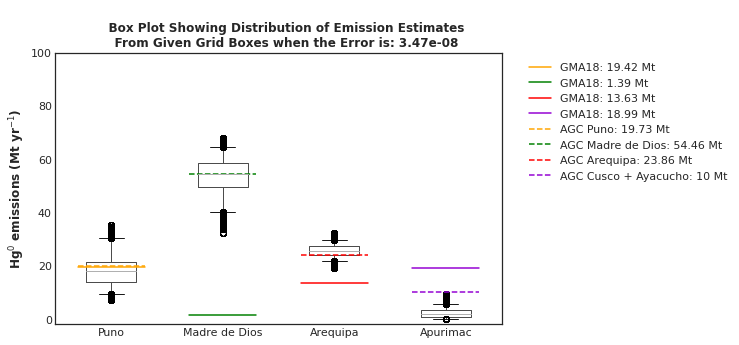



               Puno  Madre de Dios      Arequipa      Apurimac
count  50000.000000   50000.000000  50000.000000  50000.000000
mean      18.417959      53.556933     25.666218      2.216448
std        6.034299       7.212726      2.370613      1.794341
min        7.239406      32.206280     18.940482      0.000331
25%       14.052476      49.404064     24.130030      0.714403
50%       17.837376      54.248250     25.542013      1.792259
75%       21.545726      58.480142     27.239644      3.314543
max       35.349106      67.974244     32.178414      9.228212


{'Puno': 1.312041317554435, 'Madre de Dios': 0.9030673613960332, 'Arequipa': 1.8062175506594471, 'Apurimac': 7.783551809350353}




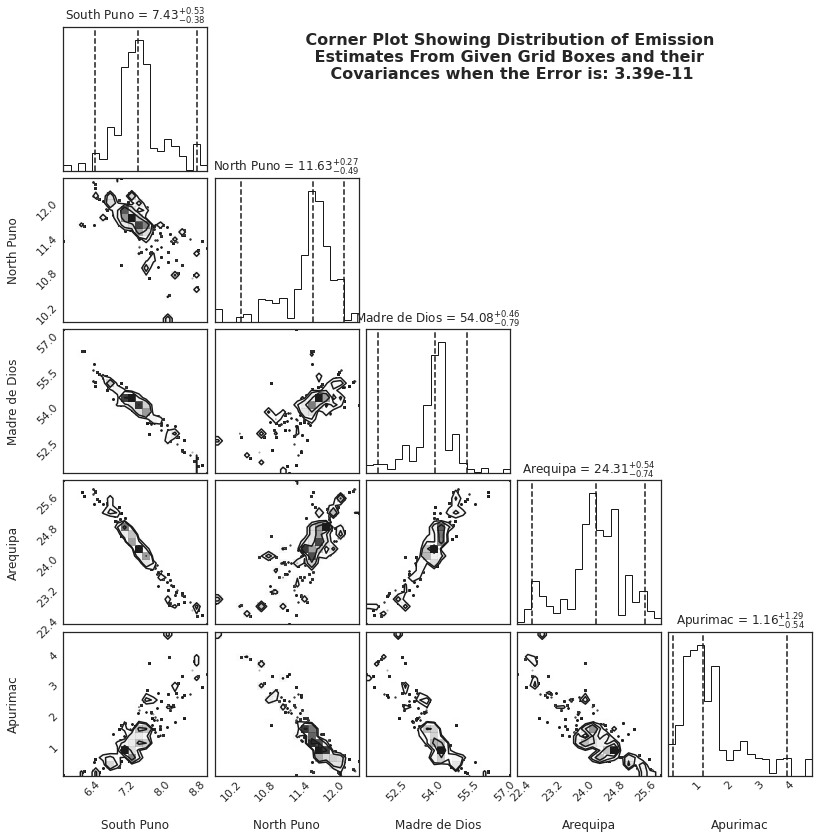

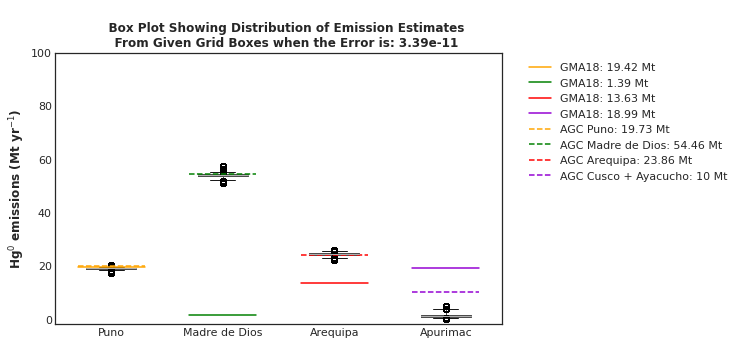



               Puno  Madre de Dios      Arequipa      Apurimac
count  50000.000000   50000.000000  50000.000000  50000.000000
mean      19.013346      53.970123     24.265284      1.442711
std        0.417416       0.892691      0.744872      0.987590
min       17.068856      51.187763     22.293408      0.043431
25%       18.846433      53.700316     23.974785      0.786243
50%       19.025749      54.079737     24.310930      1.157725
75%       19.248111      54.414308     24.722477      1.654438
max       20.240594      57.223794     25.988426      4.720935


{'Puno': 0.7166544757071982, 'Madre de Dios': 0.4898766781174331, 'Arequipa': 0.4052836562874411, 'Apurimac': 8.557288771327585}




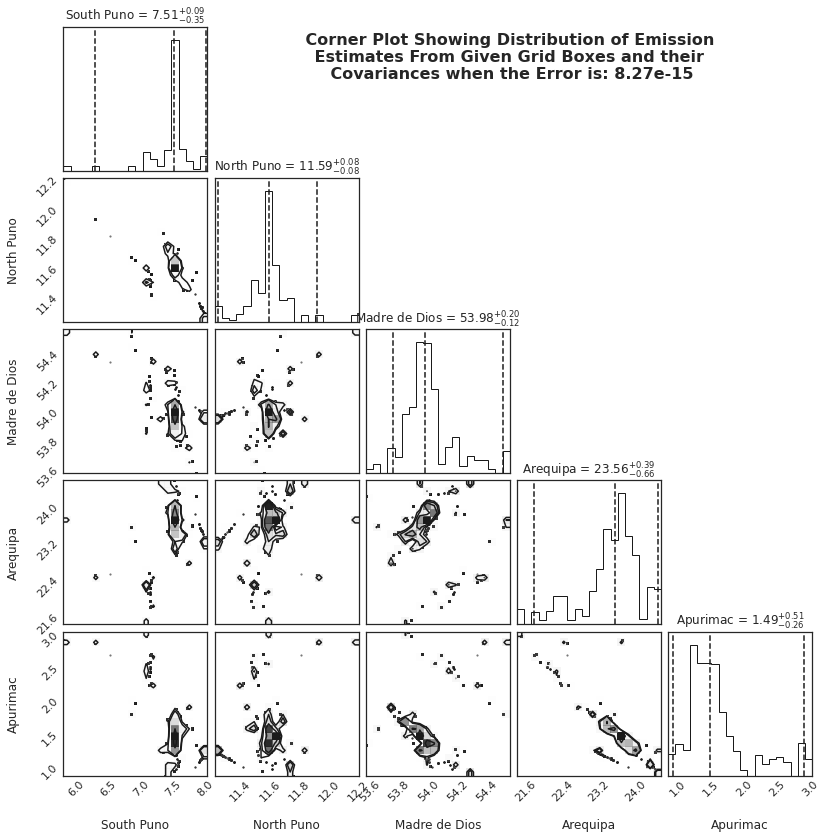

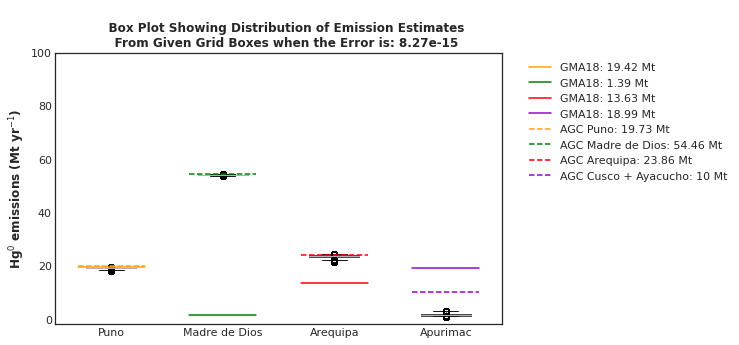



               Puno  Madre de Dios      Arequipa      Apurimac
count  50000.000000   50000.000000  50000.000000  50000.000000
mean      19.028267      54.011126     23.438330      1.615713
std        0.266054       0.177785      0.658803      0.502583
min       18.008542      53.570917     21.410395      0.855503
25%       19.082915      53.912322     23.221531      1.271062
50%       19.120927      53.980943     23.556069      1.487892
75%       19.151439      54.049171     23.827089      1.721177
max       19.409383      54.561255     24.548643      3.033770


{'Puno': 0.7017330640075627, 'Madre de Dios': 0.4488738219782462, 'Arequipa': 0.42166983525869384, 'Apurimac': 8.384286714023972}




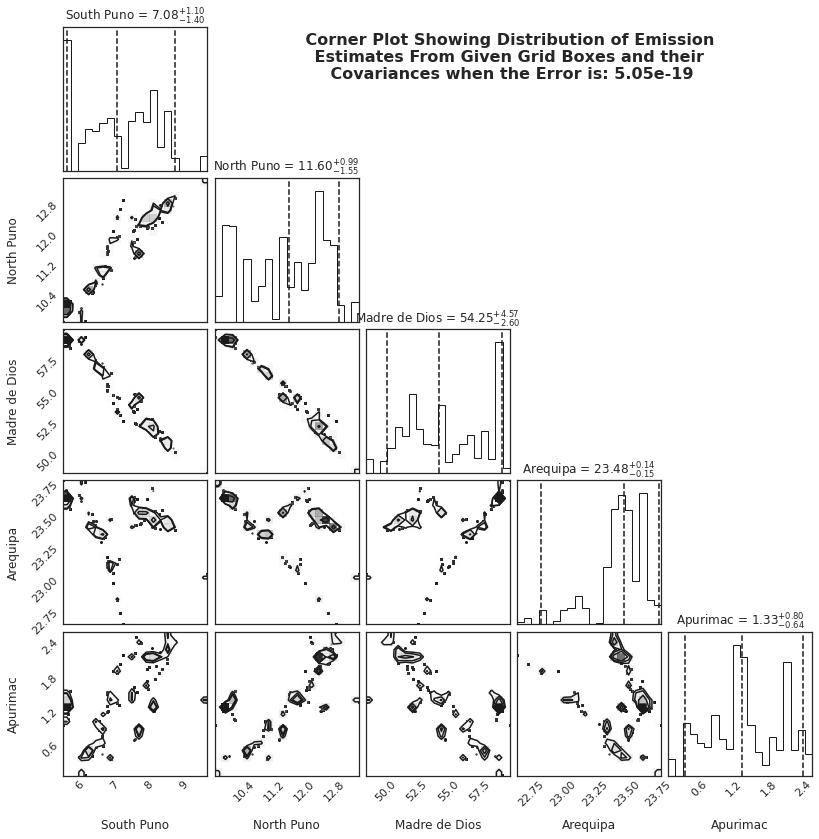

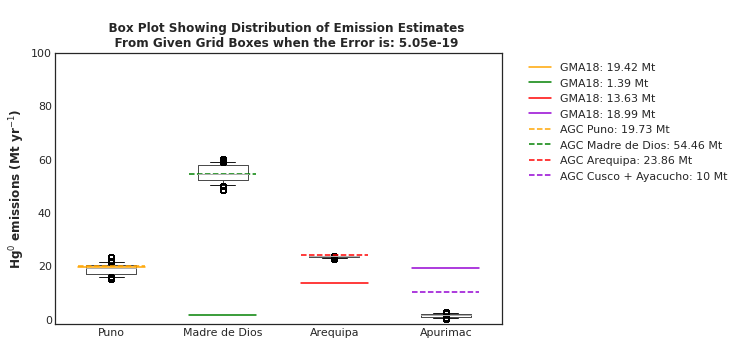



               Puno  Madre de Dios      Arequipa      Apurimac
count  50000.000000   50000.000000  50000.000000  50000.000000
mean      18.643857      54.751151     23.440363      1.372791
std        2.071382       3.076484      0.205858      0.625911
min       15.152733      48.404467     22.640853      0.050750
25%       16.767121      52.195012     23.385695      0.871461
50%       19.185232      54.249285     23.477477      1.334340
75%       20.376984      57.793769     23.597273      1.969457
max       23.128680      59.891129     23.768754      2.564667


{'Puno': 1.0861430687861713, 'Madre de Dios': 0.2911513786634501, 'Arequipa': 0.41963675132643985, 'Apurimac': 8.627209442773777}




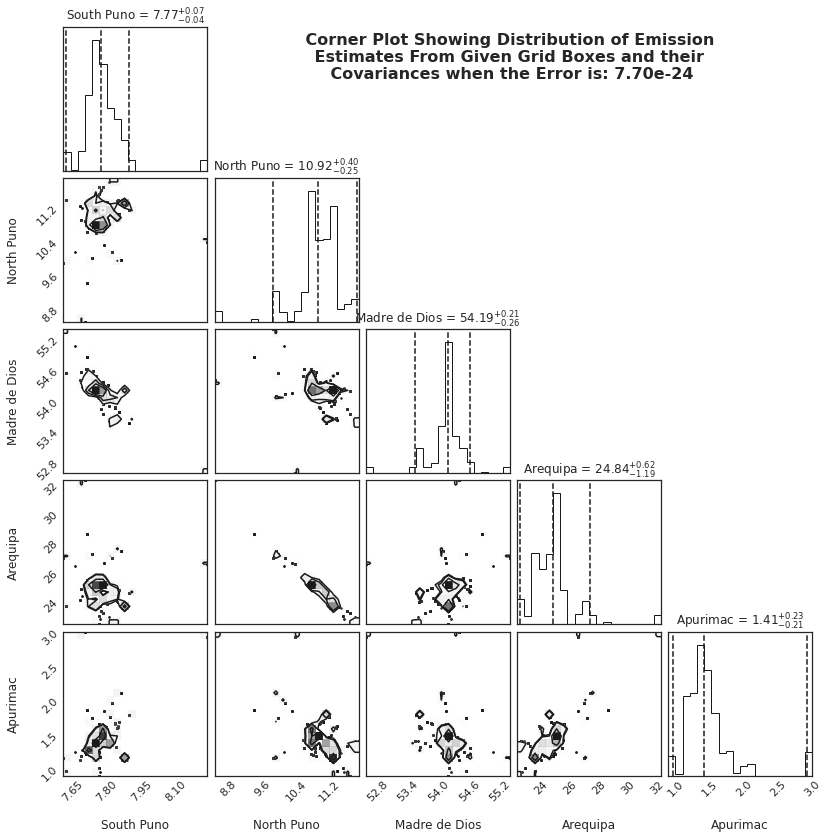

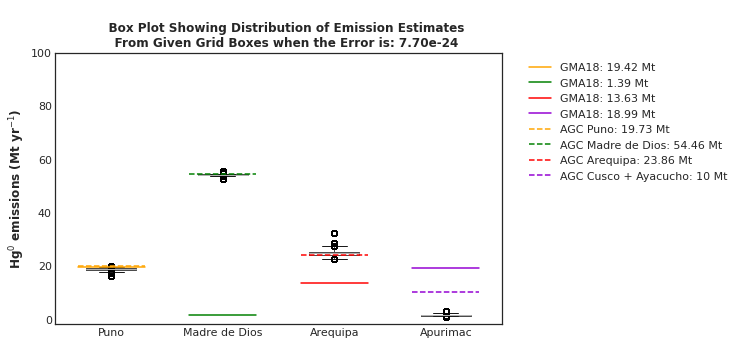



               Puno  Madre de Dios      Arequipa      Apurimac
count  50000.000000   50000.000000  50000.000000  50000.000000
mean      18.699976      54.147675     24.845139      1.469885
std        0.565903       0.375660      1.529388      0.376712
min       16.182472      52.576202     22.380625      0.888627
25%       18.543867      54.081868     23.965881      1.288835
50%       18.688049      54.189388     24.841590      1.407746
75%       19.037685      54.270425     25.198159      1.542878
max       19.697472      55.393643     32.273278      3.003736


{'Puno': 1.030023514258854, 'Madre de Dios': 0.312324903250385, 'Arequipa': 0.9851394948044181, 'Apurimac': 8.53011545452452}




In [63]:

errorVerror_95th={}
for i in range(2,20,2):
    y_err=error_dict_95th[i]
    
    sampler=super_dict_95th[i]
    # plot corner 
    corner_title= '''
    Corner Plot Showing Distribution of Emission 
    Estimates From Given Grid Boxes and their 
    Covariances when the Error is: '''+str("{:.2e}".format(y_err))
    cornerplot=plotCorner(sampler,corner_title)
    CornerFigName='cornerplot_95th'+str(i)
    cornerplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+CornerFigName)
    #plot boxplot
    box_title= '''
    Box Plot Showing Distribution of Emission Estimates
    From Given Grid Boxes when the Error is: '''+str("{:.2e}".format(y_err))
    boxplot=plotBox(sampler,box_title)
    BoxFigName='boxplot_95th'+str(i)
    boxplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+ BoxFigName)
    #rangeVerror[y_err]=df.apply(find_iqr)
    #y_err=y_err*0.5
    err_sci=str("{:.2e}".format(y_err))
    
    # df_preVtrue=df_95th.mode().T
    # df_preVtrue['trueVal']=np.array([19.73,54.46, 23.86, 10])
    # df_abse=abs(df_preVtrue['trueVal']-df_preVtrue[0])
    df_abse=calc_absE(sampler)
    errorVerror_95th[err_sci]= df_abse

In [ ]:
def model95th(theta):
            """Dummy model used here for Bayesian analysis (replace with actual GEOS-Chem function):
                Model: Y = f(theta) where theta is a set of parameters:
                    Emissions: E1, E2, and E3
            """
            Espun, Enpun, Emdd, Eaqp, Eapr=theta
            
            modified=ConstantTerm+ (Espun*Spun_sigs) + (Enpun*Npun_sigs) + (Emdd*Mdd_sigs) +(Eaqp*Aqp_sigs) +Eapr*Apr_sigs 
            
            summary =pd.DataFrame(modified)
            model_out = list(summary.apply(find_95th))
            return modified

In [ ]:
df_data=obs_Hg0_d.copy()
for i in range(2,20,2):
    mod_name='model'+str(i)

    mysamples=super_dict_95th[i].flatchain
    myparams=mysamples[np.argmax(super_dict_95th[i].flatlnprobability)]
    df_data[mod_name]=pd.DataFrame(model95th(myparams))[0].values

In [ ]:
df_data.boxplot()

In [ ]:
fig= plt.figure( figsize=[12,6])
ax= fig.add_subplot(111)
df_error[['Puno','Madre de Dios','Arequipa','Apurimac']].plot(ax=ax)
xtics=list(df_error['index'])

Title='''
How the Absolute Error Between the Mode of MCMC Emission Estimates and the AGC Emission 
Estimates changes as the Error used in the MCMC Run when the Metric is the 95$^{th}$ Percentile Range'''

ax.legend()
ax.set_ylabel('Absolute Error', fontsize = 12,fontweight="bold")
ax.set_xlabel('Error Used in MCMC Run', fontsize = 12,fontweight="bold")
ax.set_title(Title, size=12,fontweight="bold")
ax.set_xticks(list(range(len(xtics))))
ax.set_xticklabels(xtics)
plt.ylim(-2, 80)
plt.show()
fig.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/abs_errorVmcmc_error_95th')

### Plot absolute error comparison

In [ ]:
df_rangeVerror=pd.DataFrame(errorVerror_95th).T 
df_error=df_rangeVerror.reset_index()
fig= plt.figure( figsize=[12,6])
ax= fig.add_subplot(111)
df_error[['Puno','Madre de Dios','Arequipa','Apurimac']].plot(ax=ax)
xtics=list(df_error['index'])

Title='''
How the Absolute Error Between the Mode of MCMC Emission Estimates and the AGC Emission 
Estimates changes as the Error used in the MCMC Run when the Metric is the 95$^{th}$ Percentile Range'''

ax.legend()
ax.set_ylabel('Absolute Error', fontsize = 12,fontweight="bold")
ax.set_xlabel('Error Used in MCMC Run', fontsize = 12,fontweight="bold")
ax.set_title(Title, size=12,fontweight="bold")
ax.set_xticks(list(range(len(xtics))))
ax.set_xticklabels(xtics)
plt.ylim(-2, 80)
plt.show()
fig.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/abs_errorVmcmc_error_95th')

## Using mean as metric

### Generate simulation results

In [ ]:
#calculate initial error based on data
data = obs_Hg0_d['value']
res = bootstrap((data,),  np.mean)
y_err = (np.array(res.standard_error)).mean()
y_err
#specify the number of sites
ref_sites=0 # 0 is equivalent to one site 
#initialize the priors
init = np.array([7.75, 11.66, 54, 23.86, 1.5]) 
#set up dictionary for capturing the IQRs for each error per site
error_dict_mean={}
super_dict_mean={}
for i in range(2,20,2):
    print("The error in this is run: ",y_err)
    metric = 'mean'
    model = set_metric(metric)
    ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs=initEmcee(ref_sites)
    sampler=run_simulation_error(ref_sites,metric,init,y_err)
    
    #store simulation results in the super dictionary
    super_dict_mean[i]=sampler
    error_dict_mean[i]=y_err
    y_err=y_err*(0.5**i)   
    


### Generate corner plots and box plots and calculate the absolute errors

In [ ]:
errorVerror_mean={}
for i in range(2,20,2):
    y_err=error_dict_mean[i]
    
    sampler=super_dict_mean[i]
    # plot corner 
    corner_title= '''
    Corner Plot Showing Distribution of Emission 
    Estimates From Given Grid Boxes and their 
    Covariances when the Error is: '''+str("{:0.2e}".format(y_err))
    cornerplot=plotCorner(sampler,corner_title)
    CornerFigName='cornerplot_mean'+str(i)
    cornerplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+CornerFigName)
    #plot boxplot
    box_title= '''
    Box Plot Showing Distribution of Emission Estimates
    From Given Grid Boxes when the Error is: '''+str("{:.2e}".format(y_err))
    df_mean,boxplot=plotBox(sampler,box_title)
    BoxFigName='boxplot_mean'+str(i)
    boxplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+ BoxFigName)
    #rangeVerror[y_err]=df.apply(find_iqr)
    #y_err=y_err*0.5
    err_sci=str("{:.2e}".format(y_err))
    # df_preVtrue=df_mean.mode().T
    # df_preVtrue['trueVal']=np.array([19.73,54.46, 23.86, 10])
    # df_abse=abs(df_preVtrue['trueVal']-df_preVtrue[0])
    df_abse=calc_absE(sampler)
    errorVerror_mean[err_sci]= df_abse

### Plot Absolute Error Comparison for mean

In [ ]:
df_rangeVerror=pd.DataFrame(errorVerror_mean).T 
df_error=df_rangeVerror.reset_index()
fig= plt.figure( figsize=[16,8])
ax= fig.add_subplot(111)
df_error[['Puno','Madre de Dios','Arequipa','Apurimac']].plot(ax=ax)
xtics=list(df_error['index'])

Title='''
How the Absolute Error Between the Mode of MCMC Emission Estimates and the AGC 
Emission Estimates changes as the Error used in the MCMC Run when the Metric is the Mean'''

ax.legend()
ax.set_ylabel('Absolute Error', fontsize = 14,fontweight="bold")
ax.set_xlabel('Error Used in MCMC Run', fontsize = 14,fontweight="bold")
ax.set_title(Title, size=18,fontweight="bold")
ax.set_xticks(list(range(len(xtics))))
ax.set_xticklabels(xtics)
plt.ylim(-2, 80)
plt.show()
fig.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/abs_errorVmcmc_error_mean')


# Time Series Comparison with best result

In [ ]:
#Set the initial error to 
y_err = 8.84e-06
#specify the number of sites
ref_sites=0 #0 is equivalent to one site 
#initialize the priors
init = np.array([7.75, 11.66, 54, 23.86, 1.5]) 
#set up dictionary for capturing the IQRs for each error per site
error_dict_95th={}
super_dict_95th={}

print("The error in this is run: ",y_err)
metric = '95th'
model = set_metric(metric)
ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs=initEmcee(ref_sites)
sampler=run_simulation_error(ref_sites,metric,init,y_err)

#store simulation results in the super dictionary
super_dict_95th[i]=sampler
error_dict_95th[i]=y_err
y_err=y_err*(0.5**i) 

In [ ]:
 # plot corner 
corner_title= '''
Corner Plot Showing Distribution of Emission 
Estimates From Given Grid Boxes and their 
Covariances when the Error is: '''+str("{:.2e}".format(y_err))
cornerplot=plotCorner(sampler,corner_title)
CornerFigName='cornerplot_95th'+str(i)
cornerplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+CornerFigName)
#plot boxplot
box_title= '''
Box Plot Showing Distribution of Emission Estimates
From Given Grid Boxes when the Error is: '''+str("{:.2e}".format(y_err))
df_95th,boxplot=plotBox(sampler,box_title)
BoxFigName='boxplot_95th'+str(i)
boxplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+ BoxFigName)
